### Import

In [ ]:
! pip install transformers

In [ ]:
!pip install Keras-Preprocessing

In [ ]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import time
import csv
import re

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from keras.preprocessing.text import Tokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from sklearn.decomposition import PCA
from keras.utils import pad_sequences
from keras.models import Sequential
from gensim.models import Word2Vec
from sklearn.svm import LinearSVC
from keras.layers import SimpleRNN


### Reading the data and exploring

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/NLP SPAM /SpamVsHam.tsv",sep='\t',names=["label", "message"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
data.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
## Average lenght
data['message'].apply(len).mean()

80.48994974874371

In [ ]:
duplicatedRow = data[data.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [ ]:
data.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [ ]:
# Get all the ham and spam emails
ham_msg = data[data.label =='ham']
spam_msg = data[data.label=='spam']

# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

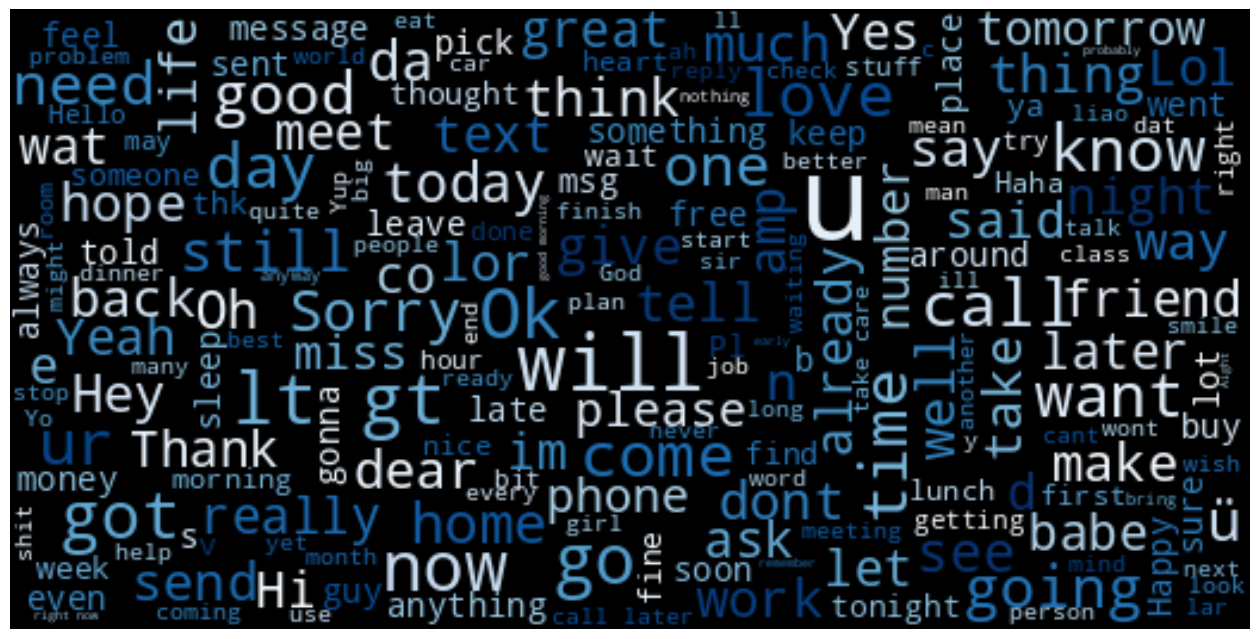

In [ ]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

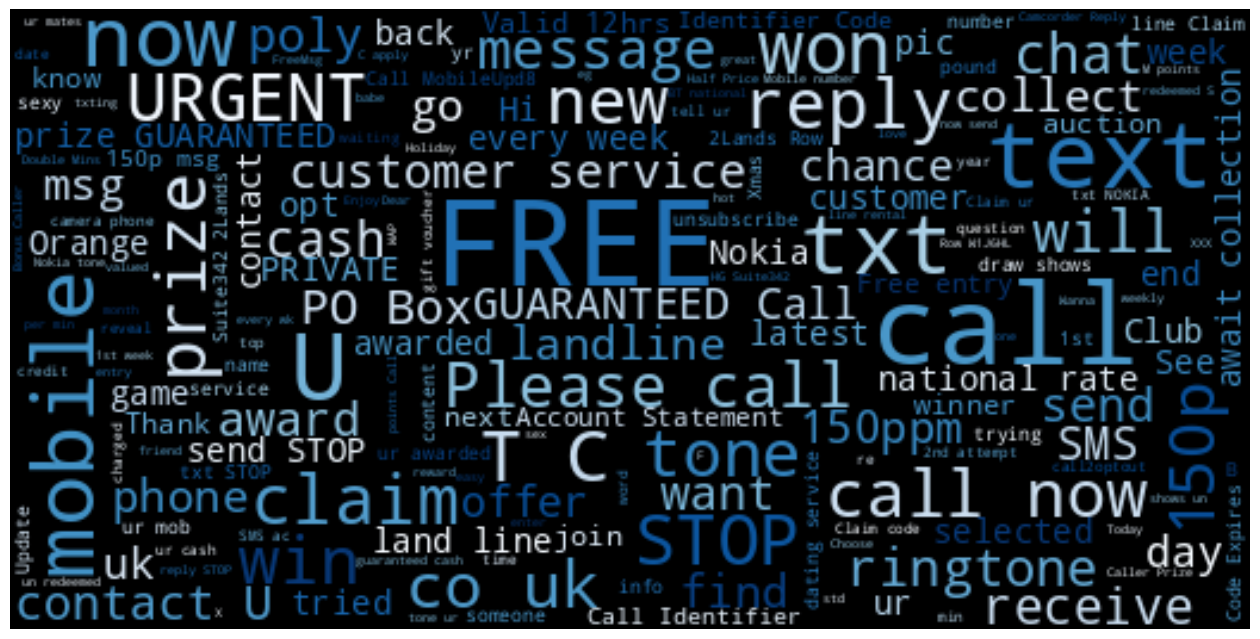

In [ ]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

In [ ]:
encoder = LabelEncoder()
encoder.fit_transform(data['label'])
data['label'] = encoder.fit_transform(data['label'])
data

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


### Data balancing

15.481865284974095

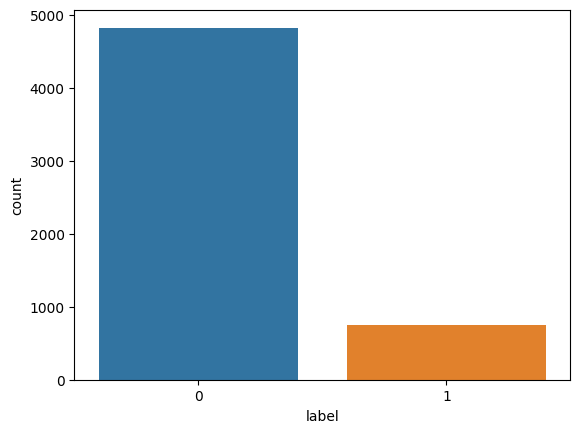

In [ ]:
# we can observe imbalance data here
sns.countplot(x='label', data=data)

# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

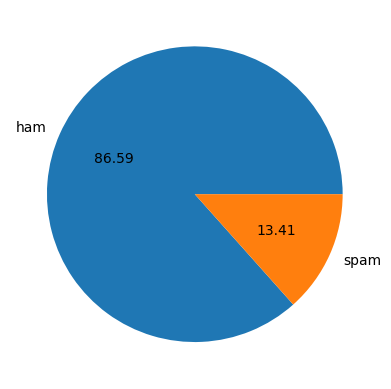

In [ ]:
plt.pie(data['label'].value_counts(), labels=['ham','spam'], autopct='%0.2f')
plt.show()

In [ ]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


<ipython-input-89-73ffc4c28eaf>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = ham_msg_df.append(spam_msg_df).reset_index(drop=True)


<Axes: xlabel='label', ylabel='count'>

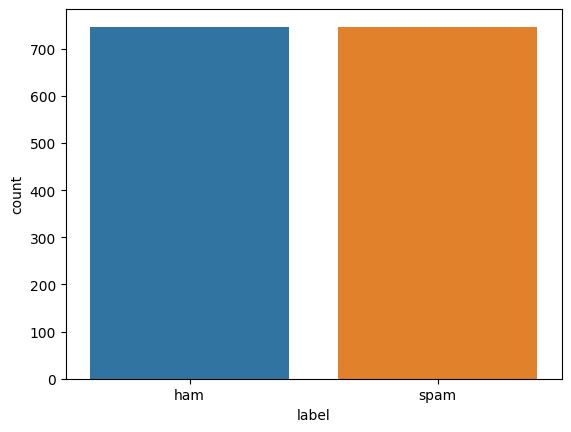

In [ ]:
data = ham_msg_df.append(spam_msg_df).reset_index(drop=True)

# we can observe balance data here
sns.countplot(x='label', data=data)

### Data Cleaning

In [ ]:
clean_txt = []
for w in range(len(data.message)):
   desc = data['message'][w].lower()

   #remove punctuation
   desc = re.sub('[^a-zA-Z]', ' ', desc)

   #remove tags
   desc=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)

   #remove digits and special chars
   desc=re.sub("(\\d|\\W)+"," ",desc)
   clean_txt.append(desc)

data['clean_message'] = clean_txt
data.head()


,label,message,clean_message
0,ham,Height of recycling: Read twice- People spend ...,height of recycling read twice people spend ti...
1,ham,Yup song bro. No creative. Neva test quality. ...,yup song bro no creative neva test quality he ...
2,ham,"Feb &lt;#&gt; is ""I LOVE U"" day. Send dis to...",feb lt gt is i love u day send dis to all ur v...
3,ham,Don't forget who owns you and who's private pr...,don t forget who owns you and who s private pr...
4,ham,Lol no. I just need to cash in my nitros. Hurr...,lol no i just need to cash in my nitros hurry ...


### Splitting the dataset

In [ ]:
# careful about overfitting with training data
# why are we slpitting we already have different files - validation set
# validation set : to avoid over fitting on the training set.

# Secluding title in a new pandas dataframe for supervised learning

X_train, X_test, y_train, y_test = train_test_split(data["clean_message"],
                                                  data["label"],
                                                  test_size=0.20,
                                                  random_state=0)

# check the size of our datasets
print('Size of training set:',X_train.shape)
print('Size of testing set:',X_test.shape)

Size of training set: (1195,)
Size of testing set: (299,)


### Feature extraction using Term Frequency-Inverse Document Frequency (TF-IDF)

In [ ]:
# tfid(it the words is common in most news body then it's number will be high) /
# bag of words (words : count) - trying to represent the words in terms of numbers.
tfidf = TfidfVectorizer()

#   Numericalize the train dataset
tfidf_train = tfidf.fit_transform(X_train)

#   Numericalize the test dataset
tfidf_test = tfidf.transform(X_test)

tfidf_train

<1195x3322 sparse matrix of type '<class 'numpy.float64'>'
	with 19049 stored elements in Compressed Sparse Row format>

In [ ]:
feature_names = tfidf.get_feature_names_out()
target_word = "cash"
if target_word in feature_names:

    word_index = np.where(feature_names == target_word)[0][0]

    word_count = tfidf_train[0, word_index]

    total_count = tfidf_train[0, :].sum()

    word_percentage = (word_count / total_count) * 100

    print(f"The word '{target_word}' comprises {word_percentage:.2f}% of the total words.")
else:
    print(f"Target word '{target_word}' is not present in the vocabulary.")

The word 'cash' comprises 0.00% of the total words.


In [ ]:
feature_names = tfidf.get_feature_names_out()
target_word = "my"
if target_word in feature_names:

    word_index = np.where(feature_names == target_word)[0][0]

    word_count = tfidf_train[0, word_index]

    total_count = tfidf_train[0, :].sum()

    word_percentage = (word_count / total_count) * 100

    print(f"The word '{target_word}' comprises {word_percentage:.2f}% of the total words.")
else:
    print(f"Target word '{target_word}' is not present in the vocabulary.")

The word 'my' comprises 6.50% of the total words.


In [ ]:
print('Train size: ',tfidf_train.shape)
print('Test size: ',tfidf_test.shape)

Train size:  (1195, 3322)
Test size:  (299, 3322)


In [ ]:
dictionary = np.asarray(tfidf.get_feature_names_out())
print(dictionary[np.random.randint(0,len(dictionary),size=20)])

['personal' 'vote' 'chosen' 'matured' 'usf' 'msg' 'la' 'response'
 'getting' 'dx' 'keralacircle' 'possible' 'fring' 'wan' 'onto' 'house'
 'also' 'suntec' 'la' 'costs']


### Feature extraction using Word2Vec

In [ ]:
# Create a Word2Vec model
# it saves syntatical information
# every work has a vector
# can assign one-hot vector and smtg different
corpus = []
for col in data.clean_message:
   word_list = col.split(" ")
   corpus.append(word_list)

#show first value
corpus[0:1]

#generate vectors from corpus
w2vmodel = Word2Vec(corpus, min_count=1, vector_size=100)


In [ ]:
def get_sentence_vector(sentence):
    vector_sum = sum([w2vmodel.wv[word] for word in sentence if word in w2vmodel.wv])
    return vector_sum / len(sentence)

X_train_word2vec = X_train.apply(get_sentence_vector)
X_test_word2vec = X_test.apply(get_sentence_vector)

In [ ]:
w2vmodel.wv.most_similar("prize")

[('or', 0.9985902309417725),
 ('claim', 0.9985681772232056),
 ('have', 0.998565673828125),
 ('with', 0.9985467791557312),
 ('a', 0.9985440373420715),
 ('you', 0.9985242486000061),
 ('your', 0.9985214471817017),
 ('our', 0.9984982013702393),
 ('cash', 0.9984877705574036),
 ('to', 0.9984772205352783)]

In [ ]:
w2vmodel.wv.most_similar("my")

[('the', 0.9998685121536255),
 ('and', 0.9998559355735779),
 ('but', 0.9998363852500916),
 ('of', 0.999836266040802),
 ('to', 0.9998331665992737),
 ('in', 0.9998307228088379),
 ('u', 0.999823808670044),
 ('can', 0.9998229742050171),
 ('that', 0.999816358089447),
 ('me', 0.9998140335083008)]

In [ ]:
print("Word2Vec vector for the first message:")
print(X_train_word2vec[0])

Word2Vec vector for the first message:
[-0.02200346  0.22298719  0.05865153  0.04519157  0.03953747 -0.51689786
  0.11231329  0.6482423  -0.32757592 -0.1642861  -0.10972549 -0.43268093
 -0.09562536  0.24561891  0.01732188 -0.24142326  0.04525099 -0.18902048
 -0.0380962  -0.5530342   0.19898562  0.11075115  0.11034255 -0.08175268
 -0.13772476 -0.04372936 -0.13140349 -0.20515485 -0.2486884  -0.01311656
  0.2654944   0.05594253  0.10650706 -0.36293897 -0.06974221  0.40594152
  0.10074484 -0.24525256 -0.23802264 -0.57305247  0.03689682 -0.24438675
 -0.07130701  0.01614705  0.25074902 -0.06761676 -0.12738666 -0.07303149
  0.18901175  0.17537518  0.15808363 -0.26936585  0.02901088 -0.01716658
 -0.21658349  0.14173926  0.1647756  -0.10330475 -0.22154346 -0.05116399
  0.13790725  0.04373041  0.08679303  0.04578619 -0.4147667   0.31102577
  0.19447733  0.25858694 -0.48339623  0.52130073 -0.09596937  0.17690827
  0.22252151 -0.00862021  0.4523025   0.19818318  0.06380857  0.05886546
 -0.26285428

### Building ML Model with TF-IDF features.

 Decision Tree Model

Training time:  0.1925370693206787 seconds
              precision    recall  f1-score   support

         ham       0.92      0.94      0.93       151
        spam       0.94      0.91      0.92       148

    accuracy                           0.93       299
   macro avg       0.93      0.93      0.93       299
weighted avg       0.93      0.93      0.93       299

Cross - validation score:  0.8561581920903955


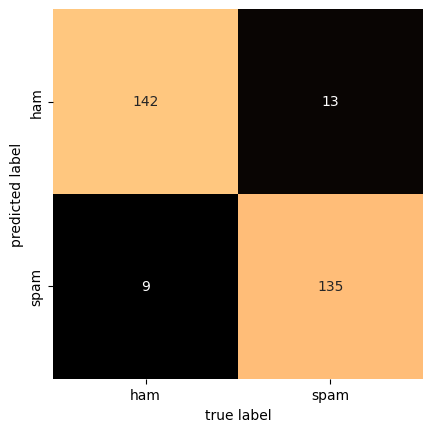

In [ ]:
#Create the model
# Random forest because it's a categorical data
decisiontree = DecisionTreeClassifier()
randomforest_tfidf = DecisionTreeClassifier(random_state=42)

#Fit the model
start_time = time.time()
randomforest_tfidf.fit(tfidf_train ,y_train);
end_time = time.time()
elapsed_time = end_time - start_time
print("Training time: ", elapsed_time, "seconds")


# predict the validation dataset
pred = randomforest_tfidf.predict(tfidf_test)


#confusion metric
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=randomforest_tfidf.classes_, yticklabels=randomforest_tfidf.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');
print(classification_report(y_test,pred))

# Cross - validation score
scores = cross_val_score(randomforest_tfidf, tfidf_test, y_test, cv=5)
print("Cross - validation score: ", scores.mean())

Naive Bayes classifier

Training time:  0.030404329299926758 seconds
              precision    recall  f1-score   support

         ham       0.96      0.93      0.95       151
        spam       0.93      0.96      0.95       148

    accuracy                           0.95       299
   macro avg       0.95      0.95      0.95       299
weighted avg       0.95      0.95      0.95       299

Cross - validation score:  0.9332203389830507


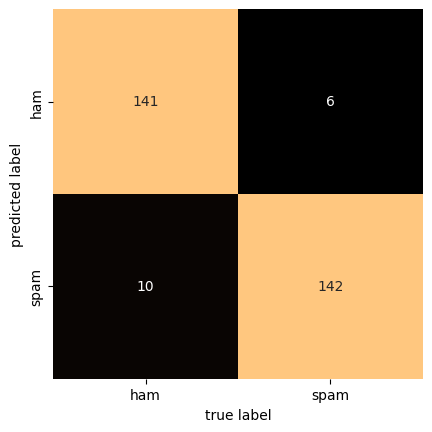

In [ ]:
#Create the model
nb_tfidf = MultinomialNB()

#Fit the model
start_time = time.time()
nb_tfidf.fit(tfidf_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time
print("Training time: ", elapsed_time, "seconds")

# predict the validation dataset
pred = nb_tfidf.predict(tfidf_test)

#confusion metric
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=nb_tfidf.classes_, yticklabels=nb_tfidf.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');
print(classification_report(y_test,pred))

# Cross - validation score
scores = cross_val_score(nb_tfidf, tfidf_test, y_test, cv=5)
print("Cross - validation score: ", scores.mean())

Logistic Regression

Training time:  0.05821800231933594 seconds
              precision    recall  f1-score   support

         ham       0.95      0.97      0.96       151
        spam       0.97      0.95      0.96       148

    accuracy                           0.96       299
   macro avg       0.96      0.96      0.96       299
weighted avg       0.96      0.96      0.96       299

Cross - validation score:  0.9231073446327682


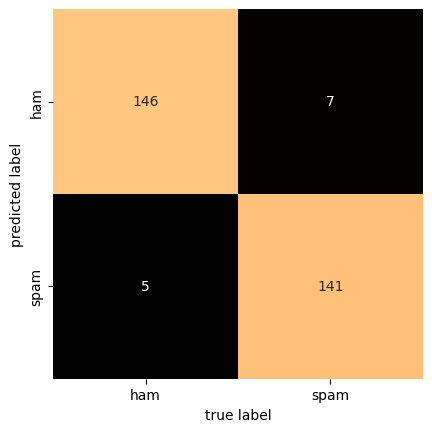

In [ ]:
#Create the model
lr_tfidf = LogisticRegression()

#Fit the model
start_time = time.time()
lr_tfidf.fit(tfidf_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time
print("Training time: ", elapsed_time, "seconds")

# predict the validation dataset
pred = lr_tfidf.predict(tfidf_test)

#confusion metric
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=lr_tfidf.classes_, yticklabels=lr_tfidf.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');
print(classification_report(y_test,pred))


# Cross - validation score
scores = cross_val_score(lr_tfidf, tfidf_test, y_test, cv=5)
print("Cross - validation score: ", scores.mean())

SVM model

Training time:  0.009149551391601562 seconds
              precision    recall  f1-score   support

         ham       0.95      0.97      0.96       151
        spam       0.97      0.95      0.96       148

    accuracy                           0.96       299
   macro avg       0.96      0.96      0.96       299
weighted avg       0.96      0.96      0.96       299

Cross - validation score:  0.9264406779661016


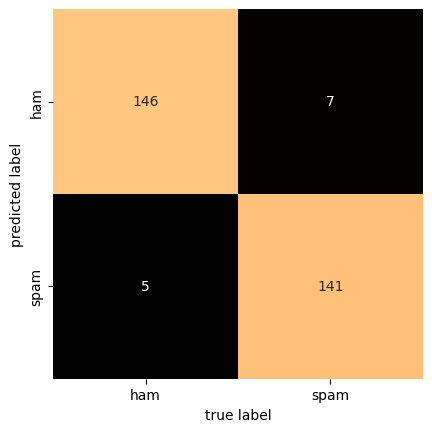

In [ ]:
#Create the model
svm_tfidf = LinearSVC()

#Fit the model
start_time = time.time()
svm_tfidf.fit(tfidf_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time
print("Training time: ", elapsed_time, "seconds")

# predict the validation dataset
pred= lr_tfidf.predict(tfidf_test)

#confusion metric
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=svm_tfidf.classes_, yticklabels=svm_tfidf.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');
print(classification_report(y_test,pred))


# Cross - validation score
scores = cross_val_score(svm_tfidf, tfidf_test, y_test, cv=5)
print("Cross - validation score: ", scores.mean())


### Building ML Model with Wrod2Vec features.

Decision Tree Model

Training time:  0.24582624435424805 seconds
              precision    recall  f1-score   support

         ham       0.72      0.72      0.72       151
        spam       0.72      0.72      0.72       148

    accuracy                           0.72       299
   macro avg       0.72      0.72      0.72       299
weighted avg       0.72      0.72      0.72       299

Cross - validation score:  0.6051412429378531


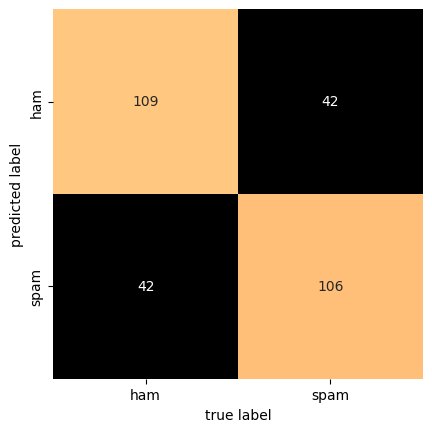

In [ ]:
#Create the model
# Random forest because it's a categorical data
decisiontree = DecisionTreeClassifier()
decisiontree_word2vec = DecisionTreeClassifier(random_state=42)

#Fit the model
start_time = time.time()
decisiontree_word2vec.fit(X_train_word2vec.tolist(), y_train.tolist());
end_time = time.time()
elapsed_time = end_time - start_time
print("Training time: ", elapsed_time, "seconds")


# predict the validation dataset
pred = decisiontree_word2vec.predict(X_test_word2vec.tolist())


#confusion metric
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=decisiontree_word2vec.classes_, yticklabels=decisiontree_word2vec.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');
print(classification_report(y_test,pred))

# Cross - validation score
scores = cross_val_score(decisiontree_word2vec, X_test_word2vec.tolist(), y_test, cv=5)
print("Cross - validation score: ", scores.mean())

Naive Bayes classifier

Training time:  0.016421079635620117 seconds
              precision    recall  f1-score   support

         ham       0.57      0.58      0.57       151
        spam       0.56      0.55      0.56       148

    accuracy                           0.57       299
   macro avg       0.57      0.57      0.57       299
weighted avg       0.57      0.57      0.57       299



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 776, in fit
    self._count(X, Y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 898, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

Cross - validation score:  nan


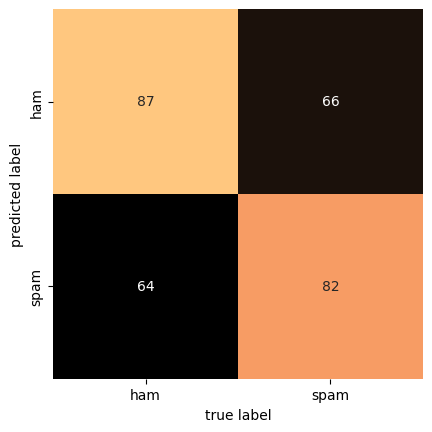

In [ ]:
#Create the model
nb_word2vec = MultinomialNB()

scaler = MinMaxScaler()
nb_train = scaler.fit_transform(X_train_word2vec.tolist())
nb_test = scaler.transform(X_test_word2vec.tolist())

#Fit the model
start_time = time.time()
nb_word2vec.fit(nb_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time
print("Training time: ", elapsed_time, "seconds")

# predict the validation dataset
pred = nb_word2vec.predict(nb_test)

#confusion metric
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=nb_word2vec.classes_, yticklabels=nb_word2vec.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');
print(classification_report(y_test,pred))

# Cross - validation score
scores = cross_val_score(nb_word2vec, nb_test, y_test, cv=5)
print("Cross - validation score: ", scores.mean())

Logistic Regression

Training time:  0.044005393981933594 seconds
              precision    recall  f1-score   support

         ham       0.56      0.57      0.57       151
        spam       0.55      0.55      0.55       148

    accuracy                           0.56       299
   macro avg       0.56      0.56      0.56       299
weighted avg       0.56      0.56      0.56       299

Cross - validation score:  0.5554237288135593


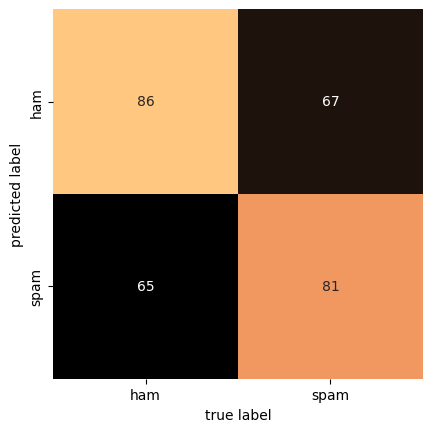

In [ ]:
#Create the model
lr_word2vec = LogisticRegression()

#Fit the model
start_time = time.time()
lr_word2vec.fit(X_train_word2vec.tolist(), y_train)
end_time = time.time()
elapsed_time = end_time - start_time
print("Training time: ", elapsed_time, "seconds")

# predict the validation dataset
pred = lr_word2vec.predict(X_test_word2vec.tolist())

#confusion metric
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=lr_word2vec.classes_, yticklabels=lr_word2vec.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');
print(classification_report(y_test,pred))


# Cross - validation score
scores = cross_val_score(lr_word2vec, X_test_word2vec.tolist(), y_test, cv=5)
print("Cross - validation score: ", scores.mean())

SVM model

Training time:  0.45960140228271484 seconds
              precision    recall  f1-score   support

         ham       0.59      0.59      0.59       151
        spam       0.58      0.59      0.59       148

    accuracy                           0.59       299
   macro avg       0.59      0.59      0.59       299
weighted avg       0.59      0.59      0.59       299

Cross - validation score:  0.5520903954802261


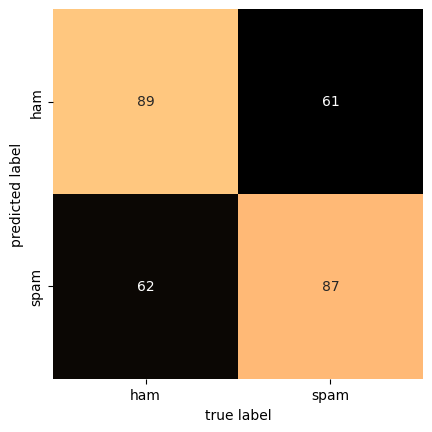

In [ ]:
#Create the model
svm_word2vec = LinearSVC()

#Fit the model
start_time = time.time()
svm_word2vec.fit(X_train_word2vec.tolist(), y_train)
end_time = time.time()
elapsed_time = end_time - start_time
print("Training time: ", elapsed_time, "seconds")

# predict the validation dataset
pred= svm_word2vec.predict(X_test_word2vec.tolist())

#confusion metric
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=svm_word2vec.classes_, yticklabels=svm_word2vec.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');
print(classification_report(y_test,pred))


# Cross - validation score
scores = cross_val_score(svm_word2vec, X_test_word2vec.tolist(), y_test, cv=5)
print("Cross - validation score: ", scores.mean())


### Deep Learning model for using Word2Vec

In [ ]:
# Pad sequences to make them of equal length
X_train_padded = pad_sequences(X_train_word2vec)
X_test_padded = pad_sequences(X_test_word2vec, maxlen=X_train_padded.shape[1])


y_train = encoder.fit_transform(y_train).astype(float)
y_test = encoder.fit_transform(y_test).astype(float)


LSTM MODEL

In [ ]:
# Build the LSTM model
lstmmodel = Sequential()
lstmmodel.add(Embedding(input_dim=len(w2vmodel.wv.key_to_index),
                        output_dim=100,
                        input_length=X_train_padded.shape[1],
                        weights=[w2vmodel.wv.vectors],
                        trainable=False))
lstmmodel.add(LSTM(128))
lstmmodel.add(Dense(1, activation='sigmoid'))

lstmmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use binary_crossentropy for binary classification

# Fit the model
start_time = time.time()
lstmmodel.fit(X_train_padded, y_train, epochs=50, batch_size=32, validation_split=0.1)
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


# Evaluate the model on the test set
loss, accuracy = lstmmodel.evaluate(X_test_padded, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)




Epoch 1/50
34/34 [==============================] - 19s 400ms/step - loss: 0.7115 - accuracy: 0.5033 - val_loss: 0.7089 - val_accuracy: 0.4833
Epoch 2/50
34/34 [==============================] - 13s 381ms/step - loss: 0.6993 - accuracy: 0.4865 - val_loss: 0.6968 - val_accuracy: 0.4833
Epoch 3/50
34/34 [==============================] - 10s 297ms/step - loss: 0.6961 - accuracy: 0.4688 - val_loss: 0.6926 - val_accuracy: 0.5167
Epoch 4/50
34/34 [==============================] - 12s 353ms/step - loss: 0.6970 - accuracy: 0.4995 - val_loss: 0.6940 - val_accuracy: 0.4833
Epoch 5/50
34/34 [==============================] - 7s 203ms/step - loss: 0.6949 - accuracy: 0.5144 - val_loss: 0.6994 - val_accuracy: 0.4833
Epoch 6/50
34/34 [==============================] - 8s 228ms/step - loss: 0.6938 - accuracy: 0.5060 - val_loss: 0.6929 - val_accuracy: 0.5167
Epoch 7/50
34/34 [==============================] - 5s 153ms/step - loss: 0.6969 - accuracy: 0.4921 - val_loss: 0.6998 - val_accuracy: 0.4833
Ep

RNN Model

In [ ]:
# Build the RNN Model
rnnmodel = Sequential()
rnnmodel.add(Embedding(input_dim=len(w2vmodel.wv.key_to_index),
                        output_dim=100,
                        input_length=X_train_padded.shape[1],
                        weights=[w2vmodel.wv.vectors],
                        trainable=False))
rnnmodel.add(SimpleRNN(64))
rnnmodel.add(Dense(1, activation='sigmoid'))

rnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
start_time = time.time()
rnnmodel.fit(X_train_padded, y_train, epochs=50, batch_size=32, validation_split=0.1)
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


# Evaluate the model on the test set
loss, accuracy = rnnmodel.evaluate(X_test_padded, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/50
34/34 [==============================] - 2s 34ms/step - loss: 0.7050 - accuracy: 0.5042 - val_loss: 0.7040 - val_accuracy: 0.5167
Epoch 2/50
34/34 [==============================] - 1s 29ms/step - loss: 0.7055 - accuracy: 0.4847 - val_loss: 0.7018 - val_accuracy: 0.4833
Epoch 3/50
34/34 [==============================] - 2s 46ms/step - loss: 0.6973 - accuracy: 0.5051 - val_loss: 0.7026 - val_accuracy: 0.4833
Epoch 4/50
34/34 [==============================] - 2s 48ms/step - loss: 0.7006 - accuracy: 0.4642 - val_loss: 0.7067 - val_accuracy: 0.4833
Epoch 5/50
34/34 [==============================] - 2s 50ms/step - loss: 0.7015 - accuracy: 0.4800 - val_loss: 0.6936 - val_accuracy: 0.5167
Epoch 6/50
34/34 [==============================] - 2s 51ms/step - loss: 0.6967 - accuracy: 0.4986 - val_loss: 0.7010 - val_accuracy: 0.5167
Epoch 7/50
34/34 [==============================] - 1s 28ms/step - loss: 0.6975 - accuracy: 0.4949 - val_loss: 0.6926 - val_accuracy: 0.5167
Epoch 8/50
34

### Text generation model

In [ ]:
spam_emails = X_train[y_train == 1]
spam_emails

1229    do you want a new nokia i colour phone deliver...
1400    bored housewives chat n date now bt national r...
1017    call from tells u call to claim prize u have e...
977     you have been selected to stay in of top briti...
1240    thanks for your ringtone order reference numbe...
                              ...                        
1033    eerie nokia tones u rply tone title to eg tone...
1383    buy space invaders a chance win orig arcade ga...
763     your free ringtone is waiting to be collected ...
835     xclusive clubsaisai morow soiree speciale zouk...
1216    dorothy kiefer com bank of granite issues stro...
Name: clean_message, Length: 599, dtype: object

In [ ]:
# Create a tokenizer and fit it on the spam emails
tokenizer = Tokenizer()
tokenizer.fit_on_texts(spam_emails)

In [ ]:
# Convert spam emails to sequences of integers
sequences = tokenizer.texts_to_sequences(spam_emails)

In [ ]:
# Pad sequences to a fixed length for input to LSTM model
max_sequence_length = 100  # Set this to the maximum sequence length used during training
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='pre')

In [ ]:
# Generate 100 unique emails
generated_emails = set()
max_email_length = 100  # Limit the email length to prevent infinite loops
eos_token = '.'  # End-of-sentence token

In [ ]:
while len(generated_emails) < 100:
    seed_text = np.random.choice(spam_emails)  # Choose a random seed text from the spam_emails list
    email = seed_text
    input_seq = tokenizer.texts_to_sequences([seed_text])[0]

    for _ in range(max_email_length):
        input_seq_padded = pad_sequences([input_seq], maxlen=max_sequence_length, padding='pre')

        # Check if the input_seq length is less than max_sequence_length
        if len(input_seq_padded[0]) < max_sequence_length:
            input_seq_padded = pad_sequences([input_seq], maxlen=max_sequence_length, padding='post')

        predicted_prob = lstmmodel.predict(input_seq_padded)[0][-1]  # Use the last predicted probability
        predicted_word = '.' if predicted_prob < 0.5 else ''  # Predict '.' for the end of the email

        email += predicted_word
        input_seq = np.append(input_seq, 0)  # Append 0 to represent unknown token

        if predicted_word == eos_token:
            break

    # Check if the generated email is unique and add it to the set
    if email not in generated_emails:
        generated_emails.add(email)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 56ms/step


In [ ]:
# Print generated emails
for i, email in enumerate(generated_emails):
    print(f"Email {i+1}: {email}")

Email 1: thanks for your ringtone order reference number x your mobile will be charged should your tone not arrive please call customer services from colour red text colour txtstar.
Email 2: rock yr chik get s of filthy films xxx pics on yr phone now rply filth to saristar ltd e yt p per days stop cancel.
Email 3: a link to your picture has been sent you can also use http alto co uk wave wave asp o .
Email 4: private your account statement for shows unredeemed bonus points to claim call identifier code expires .
Email 5: sunshine quiz win a super sony dvd recorder if you canname the capital of australia text mquiz to b
Email 6: congratulations ur awarded of cd vouchers or gift guaranteed free entry wkly draw txt music to 
Email 7: today s offer claim ur worth of discount vouchers text yes to now savamob member offers mobile t cs sub unsub reply x.
Email 8: free entry in a weekly comp for a chance to win an ipod txt pod to to get entry std txt rate t c s apply for details .
Email 9: dea

### Generated samples running throught ML TF_IDF

In [ ]:
# Create an array of size 100 with all values as 1
spam_output_TFIDF = np.full(100, "spam")

In [ ]:
tfidf_generated_emails = tfidf.transform(generated_emails)

Decision Tree Model

              precision    recall  f1-score   support

        spam       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



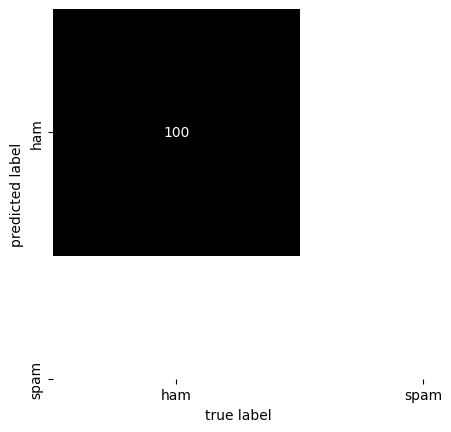

In [ ]:
# predict the generated sample dataset
pred = randomforest_tfidf.predict(tfidf_generated_emails)

#confusion metric
cm = confusion_matrix(spam_output_TFIDF,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=randomforest_tfidf.classes_, yticklabels=randomforest_tfidf.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(spam_output_TFIDF,pred))


Naive Bayes classifier


              precision    recall  f1-score   support

         ham       0.00      0.00      0.00         0
        spam       1.00      0.99      0.99       100

    accuracy                           0.99       100
   macro avg       0.50      0.49      0.50       100
weighted avg       1.00      0.99      0.99       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


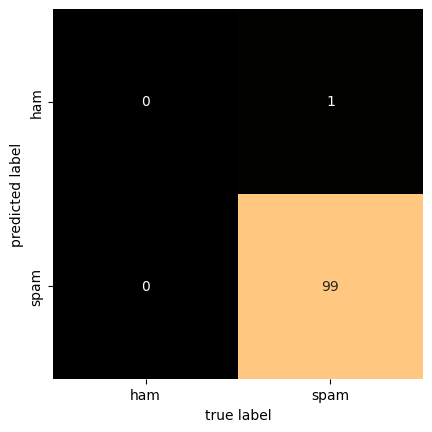

In [ ]:
# predict the generated sample dataset
pred = nb_tfidf.predict(tfidf_generated_emails)

#confusion metric
cm = confusion_matrix(spam_output_TFIDF,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=nb_tfidf.classes_, yticklabels=nb_tfidf.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(spam_output_TFIDF,pred))


Logistic Regression

              precision    recall  f1-score   support

         ham       0.00      0.00      0.00         0
        spam       1.00      0.96      0.98       100

    accuracy                           0.96       100
   macro avg       0.50      0.48      0.49       100
weighted avg       1.00      0.96      0.98       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


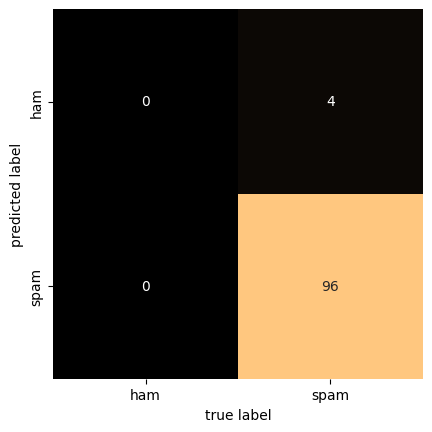

In [ ]:
# predict the generated sample dataset
pred = lr_tfidf.predict(tfidf_generated_emails)

#confusion metric
cm = confusion_matrix(spam_output_TFIDF,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=lr_tfidf.classes_, yticklabels=lr_tfidf.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(spam_output_TFIDF,pred))


SVM model

              precision    recall  f1-score   support

        spam       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



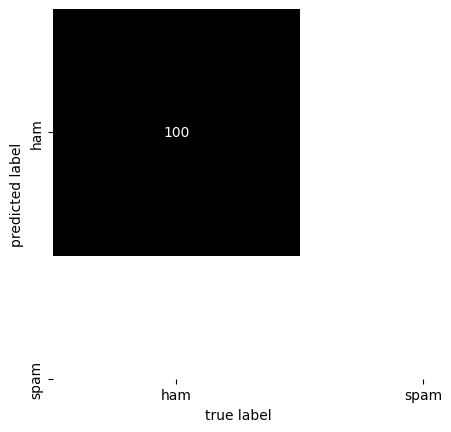

In [ ]:
# predict the generated sample dataset
pred = svm_tfidf.predict(tfidf_generated_emails)

#confusion metric
cm = confusion_matrix(spam_output_TFIDF,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=svm_tfidf.classes_, yticklabels=svm_tfidf.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(spam_output_TFIDF,pred))


### Generated samples running throught ML Word2Vec

In [ ]:
spam_output_Word2Vec = np.full((100,), "spam")

In [ ]:
# Create an empty list to store the vectors of the generated emails
generated_emails_vectors = []

# Loop through each email in the generated_emails array and apply the function
for email in generated_emails:
    email_vector = get_sentence_vector(email)  # Assuming get_sentence_vector() returns a vector
    generated_emails_vectors.append(email_vector)

# Convert the list of vectors to a NumPy array
generated_emails_word2vec = np.array(generated_emails_vectors)

Decision Tree Model

              precision    recall  f1-score   support

         ham       0.00      0.00      0.00         0
        spam       1.00      0.88      0.94       100

    accuracy                           0.88       100
   macro avg       0.50      0.44      0.47       100
weighted avg       1.00      0.88      0.94       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


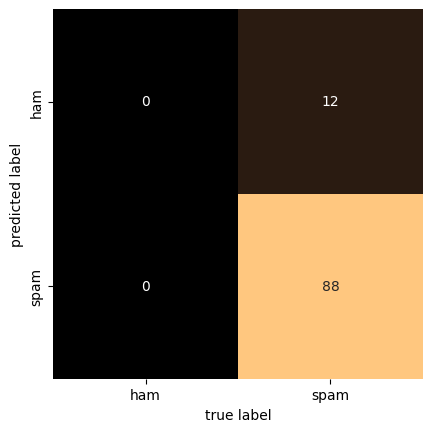

In [ ]:
# predict the generated sample dataset
pred = decisiontree_word2vec.predict(generated_emails_word2vec)

#confusion metric
cm = confusion_matrix(spam_output_Word2Vec,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=decisiontree_word2vec.classes_, yticklabels=decisiontree_word2vec.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(spam_output_Word2Vec,pred))

Naive Bayes classifier

              precision    recall  f1-score   support

        spam       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



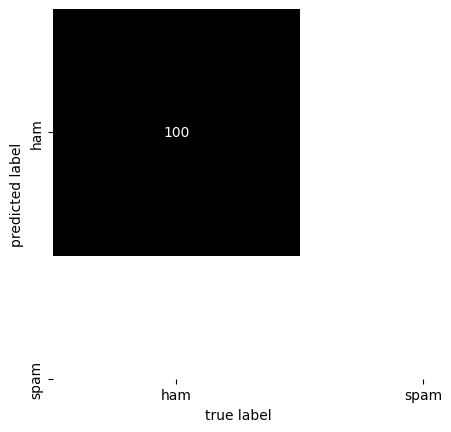

In [ ]:
# predict the generated sample dataset
pred = nb_word2vec.predict(generated_emails_word2vec)

#confusion metric
cm = confusion_matrix(spam_output_Word2Vec,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=nb_word2vec.classes_, yticklabels=nb_word2vec.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(spam_output_Word2Vec,pred))

Logistic Regression

              precision    recall  f1-score   support

         ham       0.00      0.00      0.00         0
        spam       1.00      0.49      0.66       100

    accuracy                           0.49       100
   macro avg       0.50      0.24      0.33       100
weighted avg       1.00      0.49      0.66       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


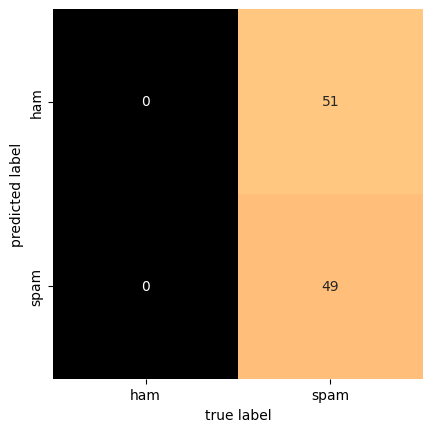

In [ ]:
# predict the generated sample dataset
pred = lr_word2vec.predict(generated_emails_word2vec)

#confusion metric
cm = confusion_matrix(spam_output_Word2Vec,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=lr_word2vec.classes_, yticklabels=lr_word2vec.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(spam_output_Word2Vec,pred))

SVM model

              precision    recall  f1-score   support

         ham       0.00      0.00      0.00         0
        spam       1.00      0.56      0.72       100

    accuracy                           0.56       100
   macro avg       0.50      0.28      0.36       100
weighted avg       1.00      0.56      0.72       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


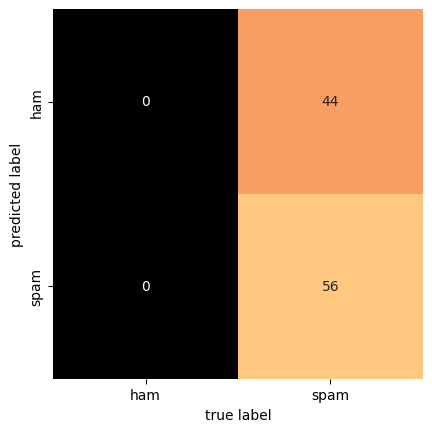

In [ ]:
# predict the generated sample dataset
pred = svm_word2vec.predict(generated_emails_word2vec)

#confusion metric
cm = confusion_matrix(spam_output_Word2Vec,pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=svm_word2vec.classes_, yticklabels=svm_word2vec.classes_, cmap="copper")
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(spam_output_Word2Vec,pred))

### Generated samples running throught Deep learning

In [ ]:
y_true = np.ones((len(generated_emails), 1))  # Ground truth labels (all 1, indicating spam)

In [ ]:
# Evaluate the model on the test set
loss, accuracy = lstmmodel.evaluate(generated_emails_word2vec, y_true)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


4/4 [==============================] - 1s 93ms/step - loss: 0.6839 - accuracy: 1.0000
Test Loss: 0.6838893890380859
Test Accuracy: 1.0


In [ ]:
# Evaluate the model on the test set
loss, accuracy = rnnmodel.evaluate(generated_emails_word2vec, y_true)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


4/4 [==============================] - 0s 15ms/step - loss: 0.7089 - accuracy: 0.0000e+00
Test Loss: 0.708945631980896
Test Accuracy: 0.0
